## We choose a window of 60 time steps
## We want to learn 48 steps and predict 12 steps.
## Each step = 1 second

In [2]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence, split_sequence_long
import math
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

2024-05-08 11:48:20.071091: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 11:48:20.098402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 11:48:20.098434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 11:48:20.099210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 11:48:20.103961: I tensorflow/core/platform/cpu_feature_guar

### Data Exploration

In [3]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [4]:
# show head
print(data.shape)
data.head()

(4597200, 6)


,pos.x,pos.y,pos.z,heading,velocity,weather
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2


In [5]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

4597200


### Time

In [6]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [7]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597200 entries, 0 to 4597199
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pos.x       float64
 1   pos.y       float64
 2   pos.z       float64
 3   heading     float64
 4   velocity    float64
 5   weather     int64  
 6   Minute sin  float64
 7   Minute cos  float64
dtypes: float64(7), int64(1)
memory usage: 280.6 MB


In [9]:
data.head()

,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2,-1.792514e-08,1.000000
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2,1.045284e-01,0.994522
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2,2.079117e-01,0.978148
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2,3.090170e-01,0.951057
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2,4.067366e-01,0.913545


### Windowing
We choose a window of 60 time steps
We want to learn 48 steps and predict 12 steps.

In [8]:
window_size = 60
grouped_data = windowing_array(data, window_size)

In [9]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

76620
60
8


### Slice and Split sequence 

In [10]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [11]:
x_train_init.shape, x_test_init.shape

((61296, 60, 8), (15324, 60, 8))

In [12]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence_long(x_train_init)

In [13]:
x_train.shape, y_train.shape

((61296, 48, 8), (61296, 12, 8))

In [14]:
x_train.shape[0], x_train.shape[1], x_train.shape[2]

(61296, 48, 8)

In [15]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [16]:
y_train.shape

(61296, 12, 2)

In [17]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence_long(x_test_init)

In [18]:
x_test.shape, y_test.shape

((15324, 48, 8), (15324, 12, 8))

In [19]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [20]:
y_test.shape

(15324, 12, 2)

### Model Configuration

In [23]:
# Define the input shape
input_shape = x_train.shape[1:]
input_shape

(48, 8)

In [24]:
# Define the output shape
outout_shape = y_train.shape[1:]
outout_shape

(12, 2)

In [25]:
# Define the output vector size
y_train_feature_nr = len(y_train[1])
output_seq_size = 2
output_features_vector=y_train_feature_nr * output_seq_size
output_features_vector

24

### Train and evaluate

In [ ]:
from models.transformer import ITPF_Transformer


model = ITPF_Transformer()

In [ ]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_vector=output_features_vector, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [ ]:
epochs = 100
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_long_2.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

In [ ]:
#model.summary()

In [21]:
model = keras.models.load_model("best_model_long_2.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

479/479 [==============================] - 10s 20ms/step - loss: 173.1331 - mae: 8.2289
Test accuracy 8.228937149047852
Test loss 173.13311767578125


In [ ]:
import matplotlib.pyplot as plt

metric = "mae"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

### Visualize the 10 best predictions

In [22]:
predictions = model.predict(x_test)

479/479 [==============================] - 10s 20ms/step


In [23]:
predictions.shape

(15324, 12, 2)

In [24]:
y_true = y_test

In [25]:

# Calculate MSE for each set of predictions
mse_values = np.mean((predictions - y_true) ** 2, axis=(1, 2))

# Find the indices of the 10 predictions with the lowest MSE
best_indices = np.argsort(mse_values)[:10]

# Select the 10 best predictions
best_predictions = predictions[best_indices]

# Retrieve the corresponding x_test entries
best_x_test = x_test[best_indices]
best_y_test = y_test[best_indices]


In [26]:
best_x_test.shape, best_predictions.shape

((10, 48, 8), (10, 12, 2))

Visualize the 10 best predictions


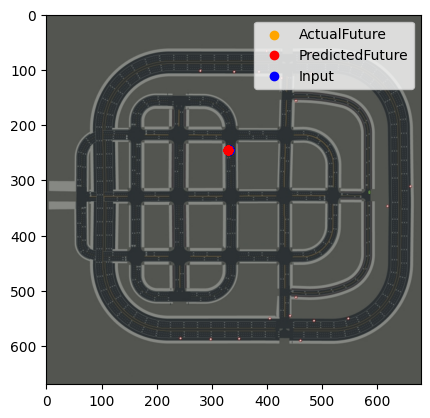

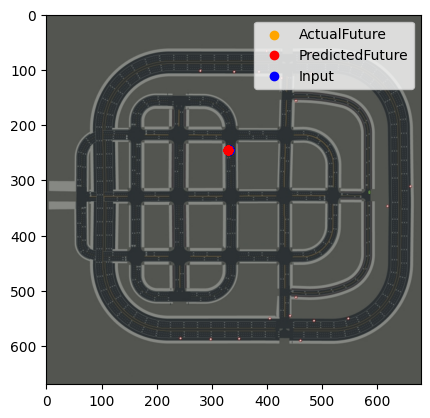

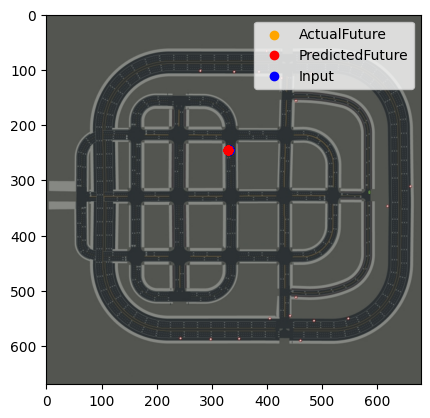

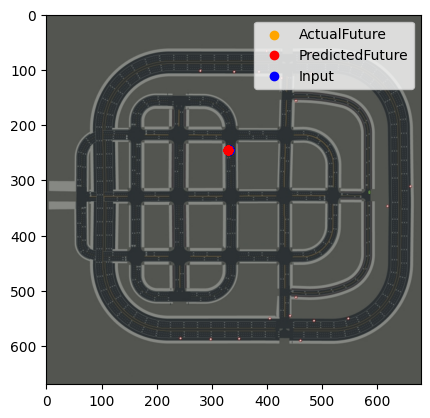

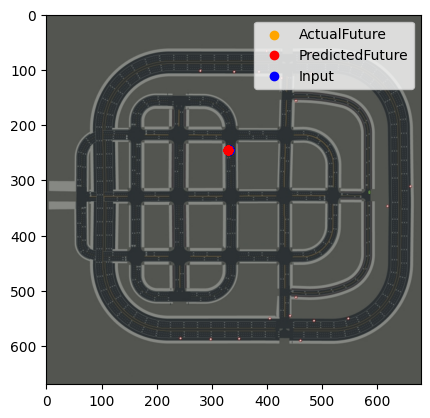

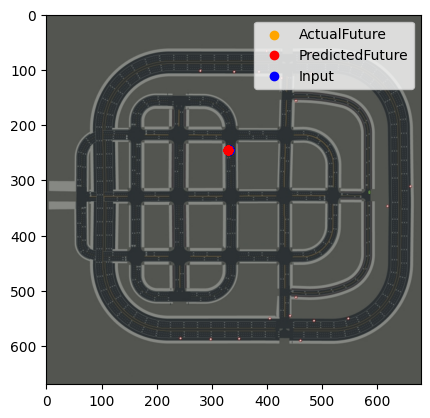

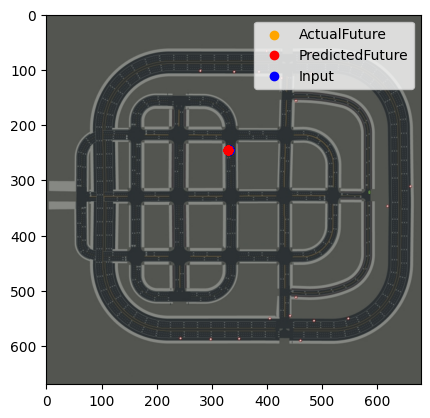

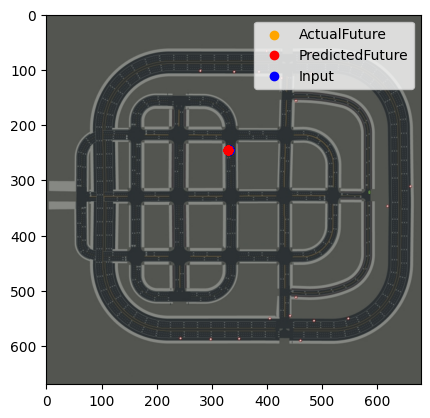

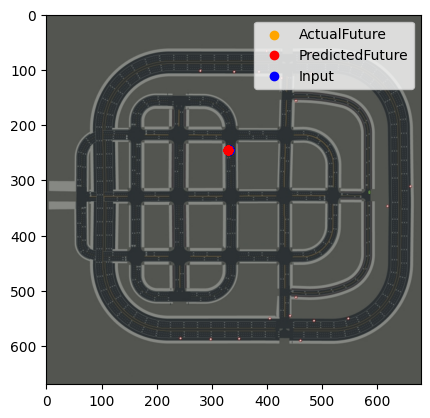

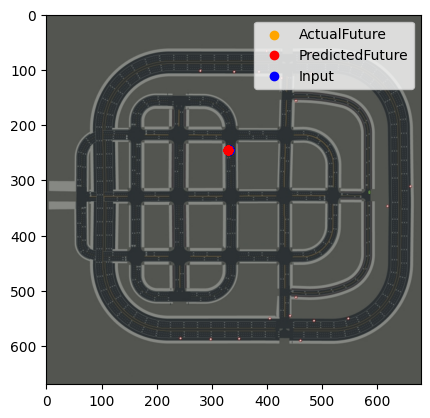

In [44]:
import random
from configs.utils_2 import plot_pred, plot_pred2


print("Visualize the 10 best predictions")

# After finding the best prediction, visualize it
if best_predictions is not None:
    for item in range(best_predictions.shape[0]):
        plot_pred2(best_x_test[:, :, :2][item], best_y_test[item], best_predictions[item])

## Explainer

In [35]:
from explainers.explainer import BlackBoxWrapper, ITPFExplainer

blackbox = BlackBoxWrapper(model=model)
explainer = ITPFExplainer()
explainer.fit_exp(
    model=blackbox, 
    x=x_train, 
    y=y_train, 
    feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"], 
    class_names=['pos.x', 'pos.y'],
    feature_nr=8,
    feature_pred_nr=2
)

In [27]:
y=best_x_test[0]

In [28]:
y.shape

(48, 8)

In [36]:
values, pertubed_data = explainer.shap_values_multivariate(y=y)

1/1 [==============================] - 0s 15ms/step


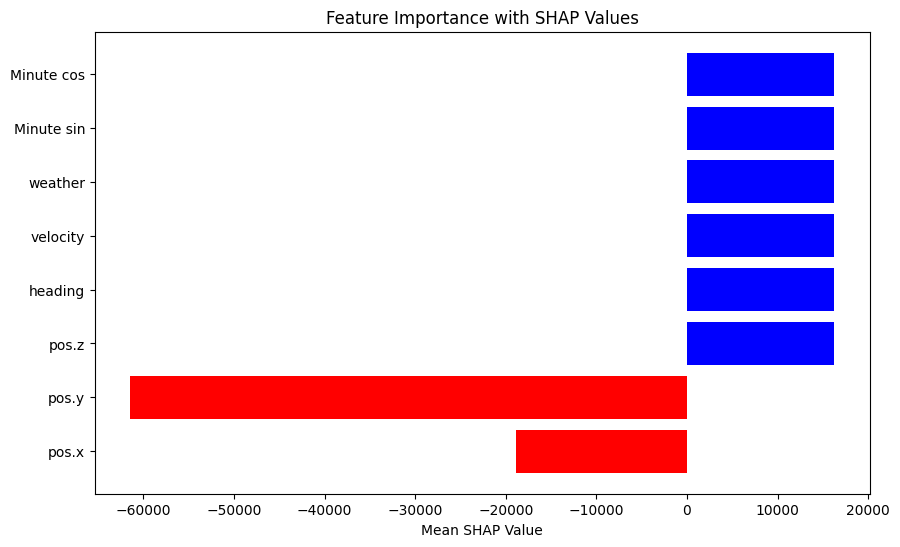

In [37]:
explainer.shap_multivariate(values)

### IMT

In [38]:
import keras.backend as K
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [39]:
from explainers.imt import IMT


explainer = IMT(blackbox.predict_2Dto3D,rmse, best_x_test[0], best_y_test[0], ["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"])

['pos.x', 'pos.y', 'pos.z', 'heading', 'velocity', 'weather', 'Minute sin', 'Minute cos']


1/1 [==============================] - 0s 14ms/step


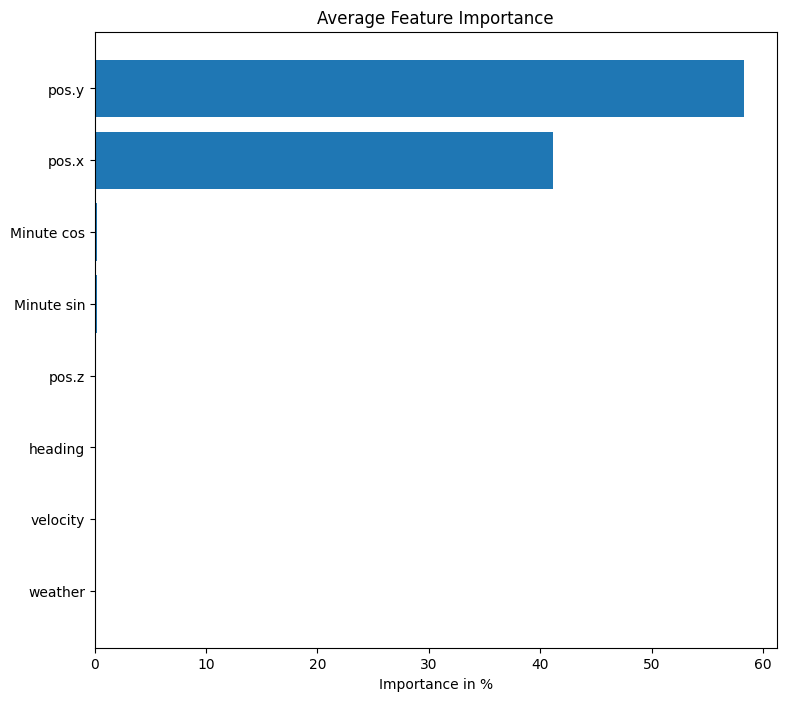

In [40]:
explainer.avg_feature_importance(y)

In [ ]:
y

In [ ]:
pertubed_data

## LIME

In [42]:
def perturb_time_series_lime(matrix, n_samples=500):

    original_trajectory = np.array(matrix)
    timesteps, features = original_trajectory.shape
    # Initialize perturbation matrix
    perturbed_samples = np.zeros((n_samples, timesteps, features))

    for sample in range(n_samples):
        random_choice = np.random.choice([-2.0, 2.0])
        random_integer = random.randint(1, 100)
        # Iterate over each feature
        for i in range(original_trajectory.shape[1]):
            perturbed_samples[sample, :, i] = original_trajectory[:, i] + ((random_integer*random_choice))
    
    return perturbed_samples

In [40]:
x = best_x_test[0]
x

array([[-4.78680420e+01,  6.83461838e+01,  2.52205078e-02,
         5.48877688e-03,  0.00000000e+00,  0.00000000e+00,
        -1.74361147e-08,  1.00000000e+00],
       [-4.78680420e+01,  6.83461838e+01,  2.52205078e-02,
         5.48877688e-03,  0.00000000e+00,  0.00000000e+00,
         1.04528449e-01,  9.94521897e-01],
       [-4.78680420e+01,  6.83461838e+01,  2.52205078e-02,
         5.48877688e-03,  0.00000000e+00,  0.00000000e+00,
         2.07911679e-01,  9.78147603e-01],
       [-4.78680420e+01,  6.83461838e+01,  2.52205078e-02,
         5.48877688e-03,  0.00000000e+00,  0.00000000e+00,
         3.09016986e-01,  9.51056519e-01],
       [-4.78680420e+01,  6.83461838e+01,  2.52205078e-02,
         5.48877688e-03,  0.00000000e+00,  0.00000000e+00,
         4.06736638e-01,  9.13545460e-01],
       [-4.78680420e+01,  6.83461838e+01,  2.52205078e-02,
         5.48877688e-03,  0.00000000e+00,  0.00000000e+00,
         4.99999985e-01,  8.66025413e-01],
       [-4.78680420e+01,  6.834618

In [45]:
samples = perturb_time_series_lime(x)

In [44]:
samples

array([[[-165.86804199,  -49.65381622, -117.97477949, ...,
         -118.        , -118.00000002, -117.        ],
        [-165.86804199,  -49.65381622, -117.97477949, ...,
         -118.        , -117.89547155, -117.0054781 ],
        [-165.86804199,  -49.65381622, -117.97477949, ...,
         -118.        , -117.79208832, -117.0218524 ],
        ...,
        [-165.86804199,  -49.65381622, -117.97477949, ...,
         -118.        , -119.        , -118.00000001],
        [-165.86804199,  -49.65381622, -117.97477949, ...,
         -118.        , -118.9945219 , -117.89547155],
        [-165.86804199,  -49.65381622, -117.97477949, ...,
         -118.        , -118.9781476 , -117.79208832]],

       [[-137.86804199,  -21.65381622,  -89.97477949, ...,
          -90.        ,  -90.00000002,  -89.        ],
        [-137.86804199,  -21.65381622,  -89.97477949, ...,
          -90.        ,  -89.89547155,  -89.0054781 ],
        [-137.86804199,  -21.65381622,  -89.97477949, ...,
          -90.

In [45]:
samples.shape

(500, 48, 8)

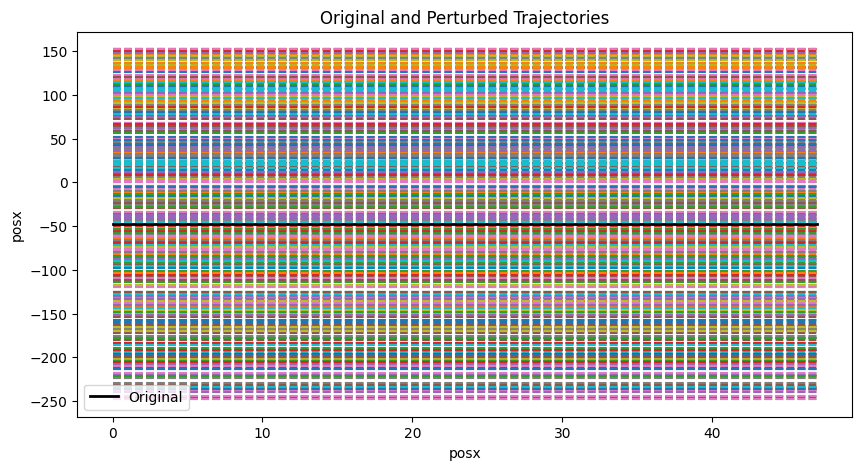

In [93]:
# Plot the original and one perturbed trajectory
plt.figure(figsize=(10, 5))
plt.plot(x[:, 0], label='Original', linewidth=2, color='black', zorder=2)
for i in range(500):
    plt.plot(samples[i, :, 0], linestyle='--', zorder=1)
plt.legend()
plt.title('Original and Perturbed Trajectories')
plt.xlabel('posx')
plt.ylabel('posx')
plt.show()

In [29]:
x_pred = best_predictions[0]

In [30]:
x_pred

array([[-48.219322,  68.36626 ],
       [-48.171288,  68.33878 ],
       [-48.158344,  68.30735 ],
       [-48.14395 ,  68.26109 ],
       [-48.121143,  68.231155],
       [-48.088   ,  68.207   ],
       [-48.053253,  68.14183 ],
       [-48.046658,  68.09288 ],
       [-48.022438,  68.08751 ],
       [-48.000023,  68.01225 ],
       [-47.976376,  67.981155],
       [-47.957077,  67.96556 ]], dtype=float32)

In [31]:
len(x_pred)

12

In [38]:
import numpy as np

def euclidean_distance(original, perturbed):
    """
    Calculates the Euclidean distance between each corresponding point in the original and perturbed trajectories.

    Parameters:
    - original (np.ndarray): Original trajectory data of shape (timesteps, features).
    - perturbed (np.ndarray): Perturbed trajectory data of shape (n_samples, timesteps, features).

    Returns:
    - distances (np.ndarray): Array of distances for each sample, shape (n_samples,)
    """
    # Subtract the original trajectory from each perturbed sample, square the results, sum across features, and take the square root
    squared_diff = np.sum((perturbed - original)**2, axis=2)
    distances = np.sqrt(np.mean(squared_diff, axis=1))
    return distances

# Example usage:
#original = np.random.rand(100, 3)  # Original trajectory
#perturbed = np.random.rand(10, 100, 3)  # 10 perturbed trajectories
#distances = euclidean_distance(original, perturbed)
#print("Distances:", distances)



In [46]:
distances = euclidean_distance(x, samples)

In [51]:
distances

array([333.75440072, 254.55844123, 147.07821049, 164.04877324,
       248.90158698, 181.01933598, 401.63665171,  67.88225099,
       497.80317396, 265.87214973, 543.05800795, 265.87214973,
       384.66608897,  11.3137085 , 367.69552622, 152.73506474,
       130.10764774, 384.66608897, 288.49956672, 181.01933598,
        56.56854249, 294.15642097, 328.09754647, 169.70562748,
       141.42135624, 311.12698372, 226.27416998, 339.41125497,
        90.50966799,  79.19595949,  28.28427125, 452.54833996,
       452.54833996, 203.64675298, 231.93102423, 294.15642097,
        73.53910524, 526.0874452 ,  73.53910524, 339.41125497,
        67.88225099, 531.74429945, 135.76450199, 181.01933598,
       260.21529548, 299.81327522,  39.59797975, 514.7737367 ,
       407.29350596,  28.28427125,   5.65685425,  56.56854249,
       407.29350596, 384.66608897, 531.74429945, 282.84271247,
        79.19595949, 554.37171645, 248.90158698, 169.70562748,
       164.04877324, 203.64675298, 152.73506474, 350.72

In [52]:
distances.shape

(500,)

In [47]:
# Get indices of the 10 samples with the smallest distances
indices = np.argsort(distances)[:10]

# Select the 10 best samples and their distances
best_samples = samples[indices]
best_distances = distances[indices]

In [54]:
indices

array([163,  50,  87,  76, 479, 203,  13, 191, 407,  80])

In [55]:
best_distances

array([ 5.65685425,  5.65685425,  5.65685425,  5.65685425,  5.65685425,
       11.3137085 , 11.3137085 , 11.3137085 , 11.3137085 , 11.3137085 ])

In [56]:
best_samples

array([[[-49.86804199,  66.34618378,  -1.97477949, ...,  -2.        ,
          -2.00000002,  -1.        ],
        [-49.86804199,  66.34618378,  -1.97477949, ...,  -2.        ,
          -1.89547155,  -1.0054781 ],
        [-49.86804199,  66.34618378,  -1.97477949, ...,  -2.        ,
          -1.79208832,  -1.0218524 ],
        ...,
        [-49.86804199,  66.34618378,  -1.97477949, ...,  -2.        ,
          -3.        ,  -2.00000001],
        [-49.86804199,  66.34618378,  -1.97477949, ...,  -2.        ,
          -2.9945219 ,  -1.89547155],
        [-49.86804199,  66.34618378,  -1.97477949, ...,  -2.        ,
          -2.9781476 ,  -1.79208832]],

       [[-45.86804199,  70.34618378,   2.02522051, ...,   2.        ,
           1.99999998,   3.        ],
        [-45.86804199,  70.34618378,   2.02522051, ...,   2.        ,
           2.10452845,   2.9945219 ],
        [-45.86804199,  70.34618378,   2.02522051, ...,   2.        ,
           2.20791168,   2.9781476 ],
        ...,


In [48]:
## Predict pertubated sample with the blackbox
pertubations_predictions = blackbox.predict(best_samples)

1/1 [==============================] - 0s 17ms/step


In [49]:
pertubations_predictions

array([[[-42.03029 ,  65.96905 ],
        [-41.961044,  65.941505],
        [-41.930042,  65.90987 ],
        [-41.898125,  65.86239 ],
        [-41.857727,  65.83253 ],
        [-41.806763,  65.809135],
        [-41.754425,  65.741585],
        [-41.73276 ,  65.692   ],
        [-41.692677,  65.68927 ],
        [-41.655037,  65.61046 ],
        [-41.616585,  65.58036 ],
        [-41.58346 ,  65.56708 ]],

       [[-54.00104 ,  70.9011  ],
        [-53.962967,  70.8744  ],
        [-53.957172,  70.8438  ],
        [-53.9495  ,  70.79925 ],
        [-53.93361 ,  70.769684],
        [-53.907772,  70.74531 ],
        [-53.880207,  70.68242 ],
        [-53.87858 ,  70.63456 ],
        [-53.860172,  70.62718 ],
        [-53.843143,  70.55461 ],
        [-53.824574,  70.52297 ],
        [-53.809673,  70.50549 ]],

       [[-42.03029 ,  65.96905 ],
        [-41.961044,  65.941505],
        [-41.930042,  65.90987 ],
        [-41.898125,  65.86239 ],
        [-41.857727,  65.83253 ],
        [-

In [50]:
len(pertubations_predictions)

10

In [ ]:
t = pertubations_predictions[0]
t

In [94]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_model(original_pred, perturbed_preds, distances):
    
    # Calculate the MSE for each perturbed sample
    mse_scores = []
    
    for pred in perturbed_preds:
        mse = mean_squared_error(original_pred, pred)
        mse_scores.append(mse)

    # Analyze sensitivity
    correlation_coefficient = np.corrcoef(distances, mse_scores)

    mse_scores = mse_scores / distances

    # Plotting for visual analysis
    plt.figure(figsize=(8, 6))
    plt.plot(mse_scores, alpha=0.7)
    plt.xlabel('Pertubated Samples')
    plt.ylabel('MSE (scores) Evaluation With the BlackBox')
    plt.title('Black-box Sensitivity Analysis')
    plt.grid(True)
    plt.show()

    return mse_scores, correlation_coefficient



# Example usage with your model and data
# model = your_trained_model  # Assume this is your trained black box model
# correlation_coeff = evaluate_model(original_sample, best_samples, model)


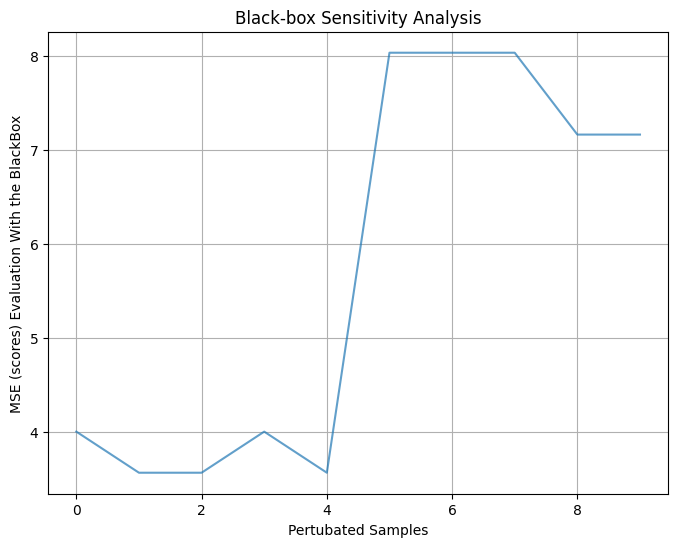

(array([4.00217572, 3.56466783, 3.56466783, 4.00217572, 3.56466783,
        8.03738918, 8.03738918, 8.03738918, 7.16564669, 7.16564669]),
 array([[1.        , 0.99432295],
        [0.99432295, 1.        ]]))

In [95]:
evaluate_model(x_pred, pertubations_predictions, best_distances)

In [61]:
df = pd.DataFrame(best_samples[1], columns=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"])


In [62]:
df

,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos
0,-45.868042,70.346184,2.025221,2.005489,2.0,2.0,2.000000,3.000000
1,-45.868042,70.346184,2.025221,2.005489,2.0,2.0,2.104528,2.994522
2,-45.868042,70.346184,2.025221,2.005489,2.0,2.0,2.207912,2.978148
3,-45.868042,70.346184,2.025221,2.005489,2.0,2.0,2.309017,2.951057
4,-45.868042,70.346184,2.025221,2.005489,2.0,2.0,2.406737,2.913545
5,-45.868042,70.346184,2.025221,2.005489,2.0,2.0,2.500000,2.866025
6,-45.868042,70.346184,2.025221,2.005489,2.0,2.0,2.587785,2.809017
7,-45.868042,70.346184,2.025221,2.005489,2.0,2.0,2.669131,2.743145
8,-45.868042,70.346184,2.025221,2.005489,2.0,2.0,2.743145,2.669131
9,-45.868042,70.346184,2.025221,2.005489,2.0,2.0,2.809017,2.587785


In [63]:
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.api import VAR

model = VAR(df)
results = model.fit(maxlags=12, trend='n')
lag_order = results.k_ar
fcst = results.forecast(df.values[-lag_order:], 12)
model_accuracy = 1 - mean_absolute_percentage_error(x_pred, fcst[:, :2])
print(model_accuracy)

0.9610070005544661


In [64]:
results.params

,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos
L1.pos.x,0.024802,-0.038038,-0.001095,-0.001084,-0.001081,-0.001081,0.000567,-0.001503
L1.pos.y,-0.038038,0.058338,0.001680,0.001663,0.001659,0.001659,-0.000870,0.002303
L1.pos.z,-0.001095,0.001680,0.000048,0.000048,0.000048,0.000048,-0.000025,0.000066
L1.heading,-0.001084,0.001663,0.000048,0.000047,0.000047,0.000047,-0.000025,0.000066
L1.velocity,-0.001081,0.001659,0.000048,0.000047,0.000047,0.000047,-0.000025,0.000065
...,...,...,...,...,...,...,...,...
L12.heading,-0.001084,0.001663,0.000048,0.000047,0.000047,0.000047,-0.000025,0.000066
L12.velocity,-0.001081,0.001659,0.000048,0.000047,0.000047,0.000047,-0.000025,0.000065
L12.weather,-0.001081,0.001659,0.000048,0.000047,0.000047,0.000047,-0.000025,0.000065
L12.Minute sin,-0.000302,0.000464,0.000013,0.000013,0.000013,0.000013,-0.000007,-0.097709


In [65]:
def extract_lagged_effects(dataframe, labels):
    """
    Extracts matrices of lagged variable effects for specified labels from a VAR model's coefficient DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing lagged coefficients.
    - labels (list of str): List of variable labels to extract lagged effects for.

    Returns:
    - dict of pd.DataFrame: A dictionary where each key is a label and the value is a DataFrame containing the coefficients
                             for all lags of that label.
    """
    results = {}
    # Loop through each label and collect the corresponding lagged effects
    for label in labels:
        # Filter rows for each label across all specified lags
        # This assumes the DataFrame's index is properly named with L1.*, L2.*, ..., L12.*
        lag_pattern = f'L[0-9]+.{label}'
        filtered_df = dataframe.filter(regex=lag_pattern, axis=0)
        results[label] = filtered_df

    return results

In [66]:
# Labels we're interested in
labels_of_interest = ['pos.x', 'pos.y']

In [67]:
# Extract effects
lagged_effects = extract_lagged_effects(results.params, labels_of_interest)


In [68]:
lagged_effects

{'pos.x':               pos.x     pos.y     pos.z   heading  velocity   weather  \
 L1.pos.x   0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081   
 L2.pos.x   0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081   
 L3.pos.x   0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081   
 L4.pos.x   0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081   
 L5.pos.x   0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081   
 L6.pos.x   0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081   
 L7.pos.x   0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081   
 L8.pos.x   0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081   
 L9.pos.x   0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081   
 L10.pos.x  0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081   
 L11.pos.x  0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081   
 L12.pos.x  0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081   
 
            Minute sin  Min

In [69]:
def calculate_average_effects(lagged_df):
    """
    Calculates the average effect of each variable on a specific label across all specified lags.

    Parameters:
    - lagged_df (pd.DataFrame): DataFrame containing the lagged coefficients for a specific label.

    Returns:
    - np.ndarray: An array containing the average effects of each variable on the label.
    """
    # Calculate the mean of each column in the DataFrame
    mean_effects = lagged_df.mean()
    
    return mean_effects.values  # Convert the Pandas Series to a NumPy array


In [70]:
label1 = calculate_average_effects(lagged_effects['pos.x'])

In [71]:
label1

array([ 0.02480235, -0.03803848, -0.0010951 , -0.00108443, -0.00108147,
       -0.00108147,  0.00056724, -0.00150144])

In [87]:
def shap_multivariate(mean_scores, features_names_list):
    values = mean_scores
    feature_names = features_names_list

    # Min-Max scaling to bring all values between -1 and 1
    #max_abs_val = np.max(np.abs(shap_values))
    #scaled_shap_values = shap_values / max_abs_val  # Scales all values to [-1, 1]

    # Determine bar colors based on the sign of the scaled Shapley values
    bar_colors = ['red' if x < 0 else 'blue' for x in values]

    # Plot
    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(feature_names))
    plt.barh(y_pos, values, align='center', color=bar_colors)
    plt.yticks(y_pos, feature_names)
    plt.xlabel('Magnitude of the coefficients effect')
    plt.title('variables significance')
    plt.show()

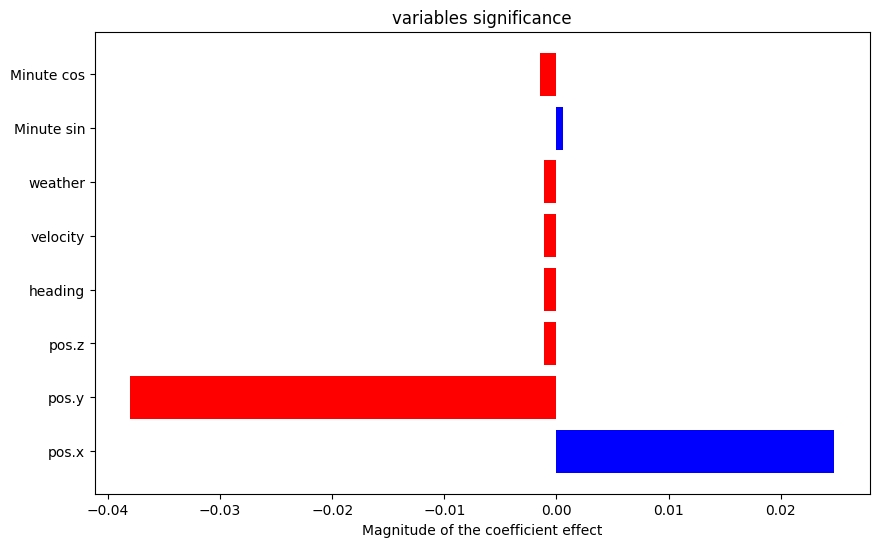

In [84]:
shap_multivariate(label1, ["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"])

In [74]:
label2 = calculate_average_effects(lagged_effects['pos.y'])

In [75]:
label2

array([-0.03803848,  0.05833826,  0.00167952,  0.00166316,  0.0016586 ,
        0.0016586 , -0.00086997,  0.00230257])

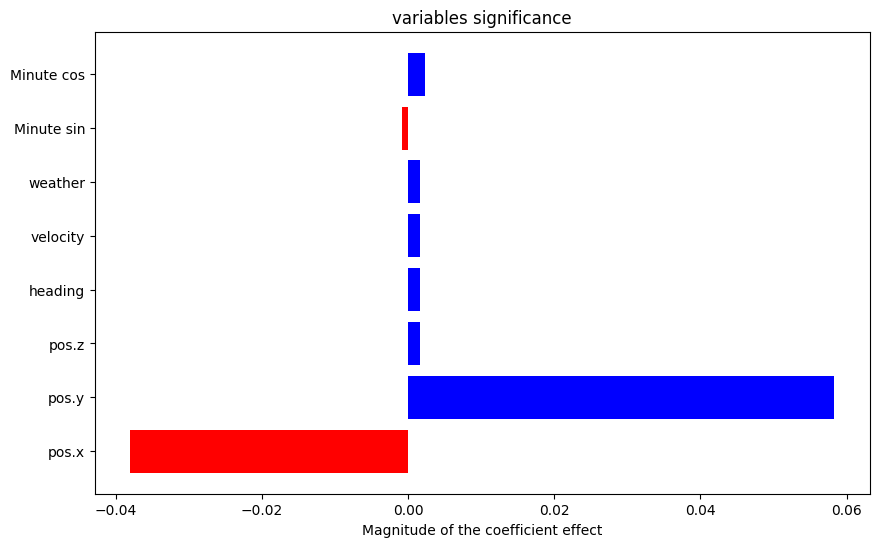

In [85]:
shap_multivariate(label2, ["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"])

          pos.x     pos.y     pos.z   heading  velocity   weather  Minute sin  \
pos.x  0.024802 -0.038038 -0.001095 -0.001084 -0.001081 -0.001081    0.000567   
pos.y -0.038038  0.058338  0.001680  0.001663  0.001659  0.001659   -0.000870   

       Minute cos  
pos.x   -0.001501  
pos.y    0.002303  


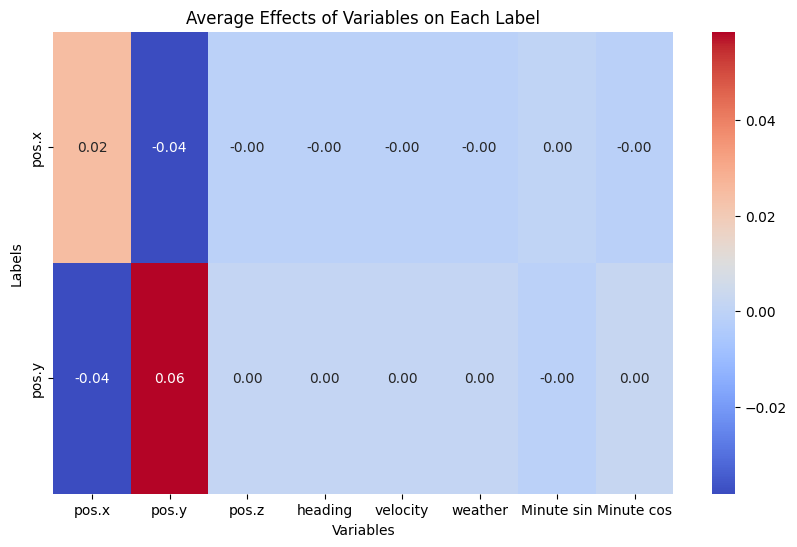

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def aggregate_effects(labels, effect_arrays):
    """
    Aggregates average effect arrays into a DataFrame for global analysis.

    Parameters:
    - labels (list of str): List of labels (e.g., 'pos.x', 'pos.y') for which the effects were calculated.
    - effect_arrays (list of np.ndarray): List of arrays containing the average effects for each label.

    Returns:
    - pd.DataFrame: A DataFrame containing the aggregated average effects.
    """
    # Create a DataFrame from the effect arrays
    effects_df = pd.DataFrame(effect_arrays, index=labels)
    
    # Assuming the columns of each input DataFrame were correctly aligned and consistent
    effects_df.columns = ['pos.x', 'pos.y', 'pos.z', 'heading', 'velocity', 'weather', 'Minute sin', 'Minute cos']
    
    return effects_df

# Example usage:
labels = ['pos.x', 'pos.y']
#effects_for_posx = np.array([-0.05, 0.02, 0.01, 0.04, -0.03, 0.001, -0.002, 0.003])  # Example array for 'pos.x'
#effects_for_posy = np.array([0.03, -0.01, 0.02, -0.05, 0.04, -0.0005, 0.001, -0.002])  # Example array for 'pos.y'

# Aggregate the effects
effects_df = aggregate_effects(labels, [label1, label2])

# Print the aggregated effects DataFrame
print(effects_df)

# Visualization of the results using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(effects_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Effects of Variables on Each Label')
plt.xlabel('Variables')
plt.ylabel('Labels')
plt.show()


In [78]:
def average_across_labels(effect_arrays):
    # Assuming all arrays are aligned and have the same length
    mean_effects = np.mean(effect_arrays, axis=0)
    return mean_effects

# Example usage
#effects_for_posx = np.array([-0.05, 0.02, 0.01, 0.04, -0.03, 0.001, -0.002, 0.003])
#effects_for_posy = np.array([0.03, -0.01, 0.02, -0.05, 0.04, -0.0005, 0.001, -0.002])
mean_effects = average_across_labels([label1, label2])
print("Mean Effects Across Labels:", mean_effects)


Mean Effects Across Labels: [-0.00661807  0.01014989  0.00029221  0.00028936  0.00028857  0.00028857
 -0.00015137  0.00040057]


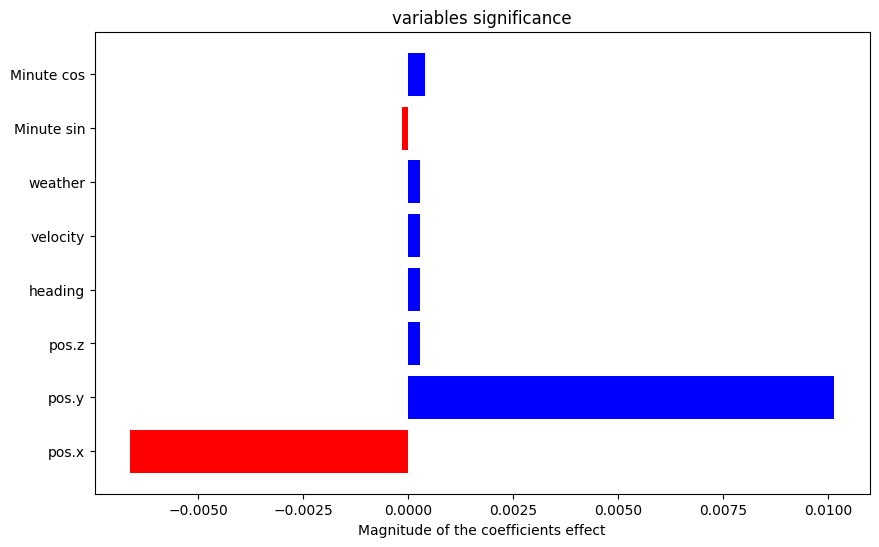

In [88]:
shap_multivariate(mean_effects, ["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"])